In [93]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [55]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 13

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle = True,image_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

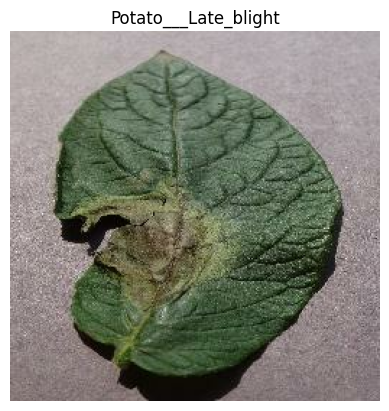

In [23]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [28]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split = 0.1, shuffle = True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    return train_ds,val_ds,test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #read image from disk and for next iteration when you need the image it will keep it in the memory
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [37]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [40]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'), #softmax normalizes prob. of classes
    
])
model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [48]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy']
)

In [65]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
    )

Epoch 1/13
54/54 [==============================] - 66s 1s/step - loss: 0.0709 - accuracy: 0.9745 - val_loss: 0.0467 - val_accuracy: 0.9792
Epoch 2/13
54/54 [==============================] - 61s 1s/step - loss: 0.0601 - accuracy: 0.9803 - val_loss: 0.1691 - val_accuracy: 0.9375
Epoch 3/13
54/54 [==============================] - 61s 1s/step - loss: 0.0518 - accuracy: 0.9780 - val_loss: 0.0316 - val_accuracy: 0.9896
Epoch 4/13
54/54 [==============================] - 62s 1s/step - loss: 0.0339 - accuracy: 0.9850 - val_loss: 0.1355 - val_accuracy: 0.9583
Epoch 5/13
54/54 [==============================] - 62s 1s/step - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.1158 - val_accuracy: 0.9583
Epoch 6/13
54/54 [==============================] - 61s 1s/step - loss: 0.0474 - accuracy: 0.9815 - val_loss: 0.1017 - val_accuracy: 0.9688
Epoch 7/13
54/54 [==============================] - 62s 1s/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.1167 - val_accuracy: 0.9531
Epoch 8/13
54/54 [==

In [66]:
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

6/6 [==============================] - 1s 224ms/step - loss: 0.0110 - accuracy: 0.9948
Test Accuracy: 99.48%


In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

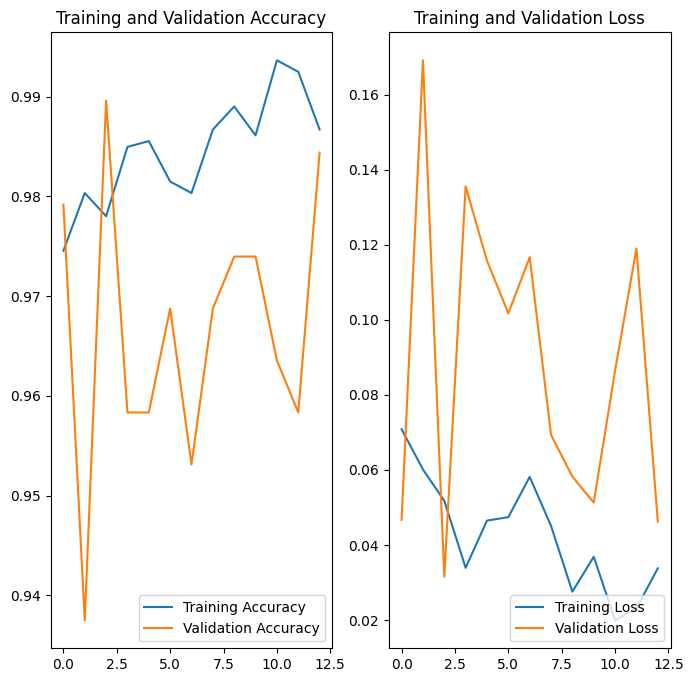

In [71]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Potato___Late_blight


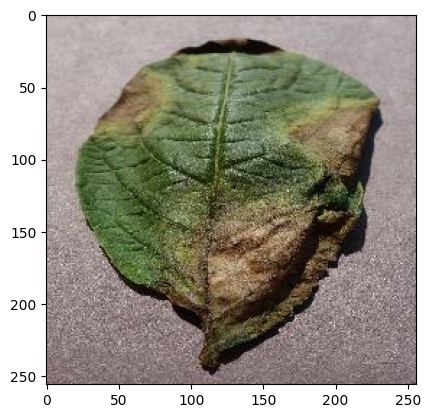

In [76]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

In [88]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


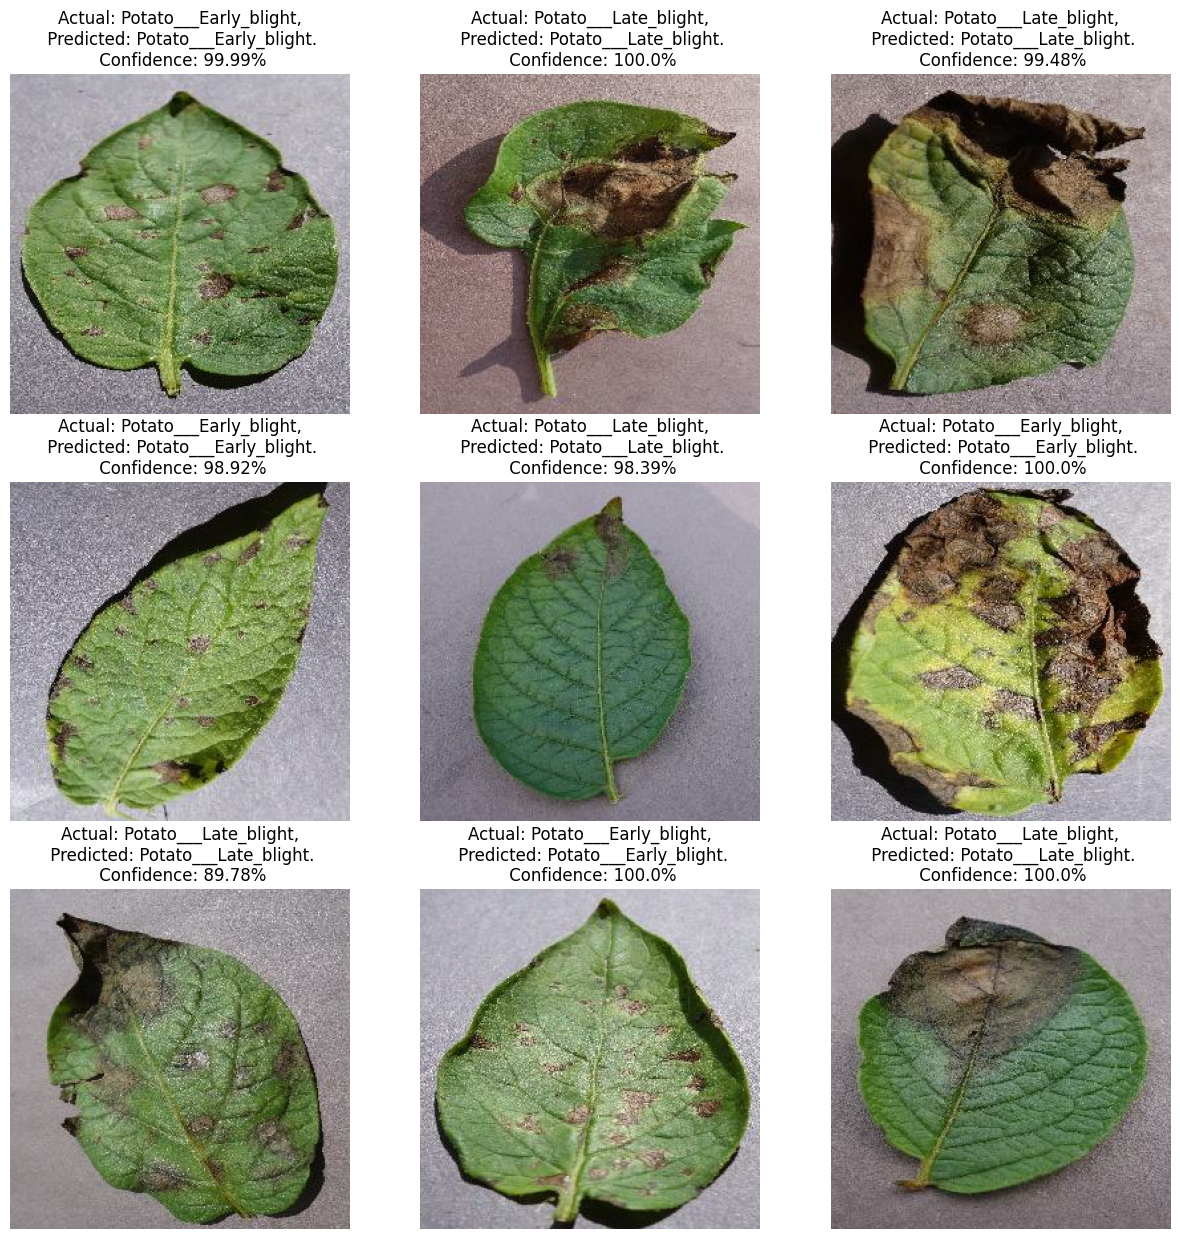

In [94]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [98]:
import os 

directory_list = os.listdir("/Users/pradhammummaleti/Desktop/jupyter/models/PlantVillage/models")
valid_directories = [int(dir_name) for dir_name in directory_list if dir_name.isdigit()]
# Check if there are any valid directories; if not, set the model_version to 0
if valid_directories:
    model_version = max(valid_directories) + 1
else:
    model_version = 0
model.save(f"/Users/pradhammummaleti/Desktop/jupyter/models/PlantVillage/models/{model_version}")

INFO:tensorflow:Assets written to: /Users/pradhammummaleti/Desktop/jupyter/models/PlantVillage/models/2/assets


INFO:tensorflow:Assets written to: /Users/pradhammummaleti/Desktop/jupyter/models/PlantVillage/models/2/assets
